# Descripción del proyecto

Como analista de datos en una tienda online, trabajé junto al equipo de marketing para aumentar los ingresos del negocio. Este proyecto se enfocó en tres tareas clave:

- Priorización de hipótesis de negocio mediante marcos de decisión (ICE y RICE).
- Implementación y monitoreo de un test A/B, evaluando su impacto sobre métricas clave como el ingreso promedio por usuario y la tasa de conversión.
- Análisis estadístico de resultados, utilizando pruebas de hipótesis para determinar la significancia de los resultados y tomar decisiones informadas.

Este análisis permitió identificar cambios viables que podrían optimizar la experiencia del usuario y generar un mayor retorno de inversión.



##  Inicialización

In [6]:
# Cargamos librerias.
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import textwrap

## Cargar datos

In [5]:
# cargamos los archivos de datos.

hipotesis = pd.read_csv('hypotheses_us.csv', delimiter=';')
ordenes = pd.read_csv('orders_us.csv')
visitas = pd.read_csv('visits_us.csv')
ordenes_bruto = pd.read_csv('orders_us.csv')

## Análisis exploratorio de datos 

In [7]:
# Preprocesamos los datos. 
hipotesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [8]:
hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [9]:
# Convertimos en minusculas las columnas para estandarizar y mejorar claridad. 

hipotesis.columns = hipotesis.columns.str.lower()

In [10]:
ordenes.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [11]:
ordenes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [12]:
print('Filas duplicadas en ordenes:', ordenes.duplicated().sum())

Filas duplicadas en ordenes: 0


In [13]:
# Cambiamos el nombre de las columnas para estandarizar y mejorar su claridad.

ordenes.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id',
    'date': 'date',
    'revenue': 'revenue',
    'group': 'group'
}, inplace=True)


In [14]:
# La columna 'date' esta en formato object y la modificamos a cadena de formato de fecha.

ordenes['date'] = pd.to_datetime(ordenes['date'])

In [15]:
visitas.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
visitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
# La columna 'date' esta en formato object y la modificamos a cadena de formato de fecha.

visitas['date'] = pd.to_datetime(visitas['date'])

In [14]:
print('Filas duplicadas en visitas:', visitas.duplicated().sum())

Filas duplicadas en visitas: 0


In [15]:
# Rango de fechas para verificar que esten dentro del rango esperado.

print(ordenes['date'].min(), ordenes['date'].max())
print(visitas['date'].min(), visitas['date'].max())


2019-08-01 00:00:00 2019-08-31 00:00:00
2019-08-01 00:00:00 2019-08-31 00:00:00


### Identificar usuarios en ambos grupos

In [17]:
# Identificar usuarios en ambos grupos
usuarios_duplicados = ordenes.groupby('visitor_id')['group'].nunique()
usuarios_ambos_grupos = usuarios_duplicados[usuarios_duplicados > 1]

# Mostrar usuarios problemáticos
print('Usuarios en ambos grupos:', usuarios_ambos_grupos.sum())

Usuarios en ambos grupos: 116


In [18]:
# Eliminar usuarios que están en ambos grupos, ya que para realizar una prueba A/B deben ser grupos independientes.
ordenes = ordenes[~ordenes['visitor_id'].isin(usuarios_ambos_grupos.index)]


##  Priorizar hipótesis

In [19]:
# Aplicar el framework ICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
hipotesis['ice'] = ((hipotesis['impact'] * hipotesis['confidence']) / hipotesis['effort']).round(1)

In [19]:
# Aplicar el framework RICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
hipotesis['rice'] = ((hipotesis['reach'] * hipotesis['impact'] * hipotesis['confidence']) / hipotesis['effort']).round(1)

In [20]:
# Mostramos los resultados de 'ICE' y 'RICE' en orden descendente.
print(hipotesis[['hypothesis', 'ice']].sort_values(by=['ice'], ascending=False))
print()
print(hipotesis[['hypothesis', 'rice']].sort_values(by=['rice'], ascending=False))



                                          hypothesis   ice
8  Launch a promotion that gives users discounts ...  16.2
0  Add two new channels for attracting traffic. T...  13.3
7  Add a subscription form to all the main pages....  11.2
6  Show banners with current offers and sales on ...   8.0
2  Add product recommendation blocks to the store...   7.0
1  Launch your own delivery service. This will sh...   2.0
5  Add a customer review page. This will increase...   1.3
3  Change the category structure. This will incre...   1.1
4  Change the background color on the main page. ...   1.0

                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre

In [21]:
# Asignar rankings basados en ICE y RICE.
hipotesis['ice_rank'] = hipotesis['ice'].rank(ascending=False, method='dense')
hipotesis['rice_rank'] = hipotesis['rice'].rank(ascending=False, method='dense')

# Crear un DataFrame con los resultados ordenados.
hipotesis 

,hypothesis,reach,impact,confidence,effort,ice,rice,ice_rank,rice_rank
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.3,40.0,2.0,3.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.0,4.0,6.0,6.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.0,56.0,5.0,2.0
3,Change the category structure. This will incre...,8,3,3,8,1.1,9.0,8.0,5.0
4,Change the background color on the main page. ...,3,1,1,1,1.0,3.0,9.0,7.0
5,Add a customer review page. This will increase...,3,2,2,3,1.3,4.0,7.0,6.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.0,40.0,4.0,3.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.2,112.0,3.0,1.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.2,16.2,1.0,4.0


In [22]:
print('Hipotesis priorizada por su puntaje mas alto en RICE:', hipotesis['hypothesis'][7])

Hipotesis priorizada por su puntaje mas alto en RICE: Add a subscription form to all the main pages. This will help you compile a mailing list


**Notas:**


ICE (Impact, Confidence, Effort):
Priorizó hipótesis con el mejor balance entre impacto y confianza en relación al esfuerzo necesario. Estas hipótesis son ideales para implementar rápidamente y generar resultados efectivos.


RICE (Reach, Impact, Confidence, Effort):
Introducir el alcance (Reach) cambió el enfoque hacia hipótesis que afectan a un mayor número de usuarios, incluso si su impacto y confianza no son los más altos.

Decisión final:

La hipótesis "Add a subscription form to all the main pages" fue priorizada debido a su puntaje más alto en RICE, lo que indica un alto impacto potencial en un amplio número de usuarios.

Este análisis nos permitió identificar una hipótesis con el mayor potencial para aumentar los ingresos, considerando tanto el esfuerzo necesario como el alcance y el impacto esperado. Esto asegura que las decisiones estratégicas estén respaldadas por un enfoque cuantitativo.


##  Análisis del test A/B

###  Representaremos gráficamente el ingreso acumulado por grupo


In [23]:
# Vamos a crear una matriz con valores únicos de parejas fecha-grupo con el método.

dates_groups = ordenes[['date', 'group']].drop_duplicates()

# Con este código, es como si hubiéramos estado calculando los resultados de nuestra prueba todos los días hasta la fecha actual y almacenándolos en las filas.

ordenes_acumuladas = dates_groups.apply(
    lambda x: ordenes[
        np.logical_and(
            ordenes['date'] <= x['date'], ordenes['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'visitor_id': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])



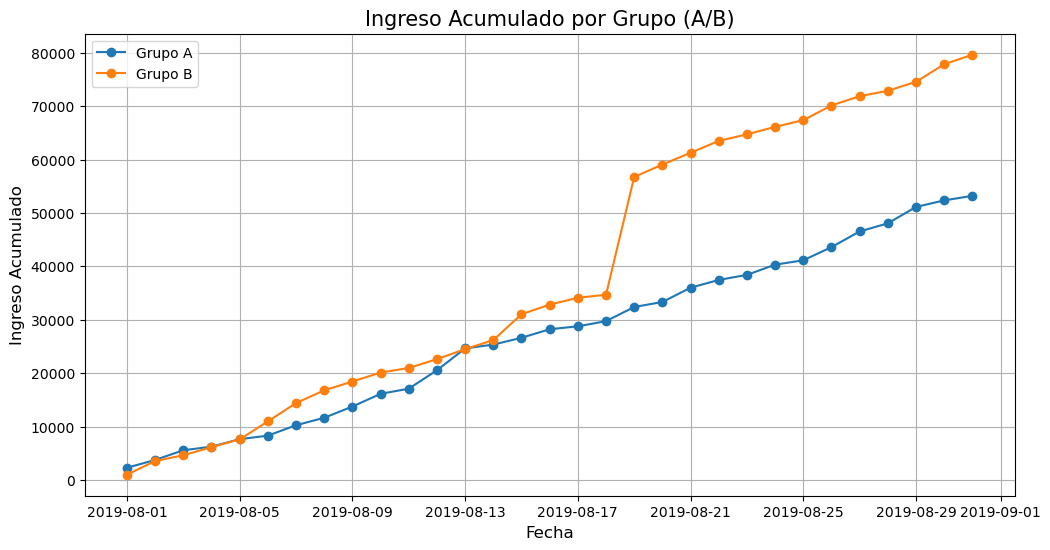

In [24]:
# Separamos los datos del grupo 'A' y 'B' para poder graficar

ordenes_A = ordenes_acumuladas[ordenes_acumuladas['group']== 'A']

ordenes_B = ordenes_acumuladas[ordenes_acumuladas['group']== 'B']

# Representamos gráficamente el ingreso acumulado por grupo.

plt.figure(figsize=(12,6))

# Graficar los ingresos acumulados del grupo A
plt.plot(ordenes_A['date'], ordenes_A['revenue'], label='Grupo A', marker='o')

# Graficar los ingresos acumulados del grupo B
plt.plot(ordenes_B['date'], ordenes_B['revenue'], label='Grupo B', marker='o')

plt.title('Ingreso Acumulado por Grupo (A/B)', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ingreso Acumulado', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()



**Notas:** 

Los datos sugieren que el grupo B es superior en términos de generación de ingresos acumulados. Esto indica que la estrategia implementada en este grupo debería considerarse para su implementación general.

Sin embargo, antes de tomar decisiones finales, sería importante realizar una prueba estadística para determinar si la diferencia observada es significativa o si puede atribuirse a la variabilidad aleatoria.

## Representaremos gráficamente el tamaño de pedido promedio acumulado por grupo

In [25]:
# Renombramos las columnas para mejor intepretacion de los datos.
ordenes_acumuladas.columns = ['date', 'group', 'cumulative_transactions', 'cumulative_visitors', 'cumulative_revenue']

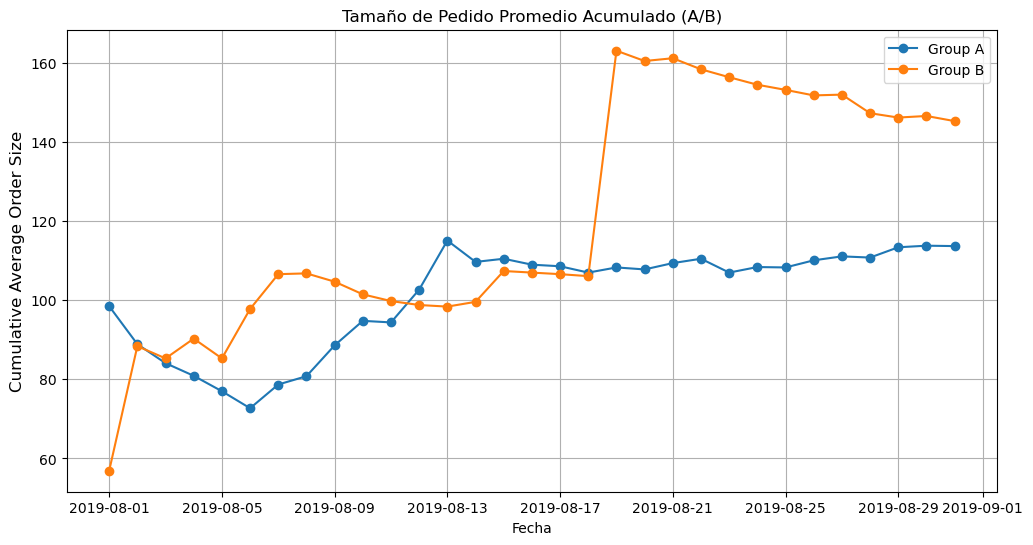

In [26]:
# Calcular el tamaño de pedido promedio acumulado.

ordenes_acumuladas['avg_order_size'] = (ordenes_acumuladas['cumulative_revenue'] / ordenes_acumuladas['cumulative_transactions']).round(1)

# Representamos gráficamente el tamaño de pedido promedio acumulado por grupo.

# Separar los datos por grupo A y B
orders_A = ordenes_acumuladas[ordenes_acumuladas['group'] == 'A']
orders_B = ordenes_acumuladas[ordenes_acumuladas['group'] == 'B']

# Configurar el gráfico.
plt.figure(figsize=(12, 6))

# Graficar el tamaño de pedido promedio acumulado para el grupo A.
plt.plot(orders_A['date'], orders_A['avg_order_size'], label='Group A', marker='o')

# Graficar el tamaño de pedido promedio acumulado para el grupo B.
plt.plot(orders_B['date'], orders_B['avg_order_size'], label='Group B', marker='o')


plt.title('Tamaño de Pedido Promedio Acumulado (A/B)')
plt.xlabel('Fecha')
plt.ylabel('Cumulative Average Order Size', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico.
plt.show()



**Notas:**

Durante el periodo observado (agosto de 2019), el Grupo B muestra un incremento notable y sostenido en el tamaño promedio de los pedidos, especialmente a partir del 18 de agosto, donde se observa un salto abrupto y una tendencia consistentemente superior al Grupo A.

Por el contrario, el Grupo A mantiene un crecimiento más gradual y estable, sin cambios bruscos.

## Representamos gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas

In [34]:
# Combinar los datos de los grupos A y B por la columna 'date'.

merged_A_B = orders_A[['date', 'avg_order_size']].merge(
    orders_B[['date', 'avg_order_size']], on='date',
    suffixes=('_A', '_B'))

# Calcular la diferencia relativa.

merged_A_B['relative_difference'] = ((merged_A_B['avg_order_size_B'] - merged_A_B['avg_order_size_A']) / merged_A_B['avg_order_size_A']) * 100

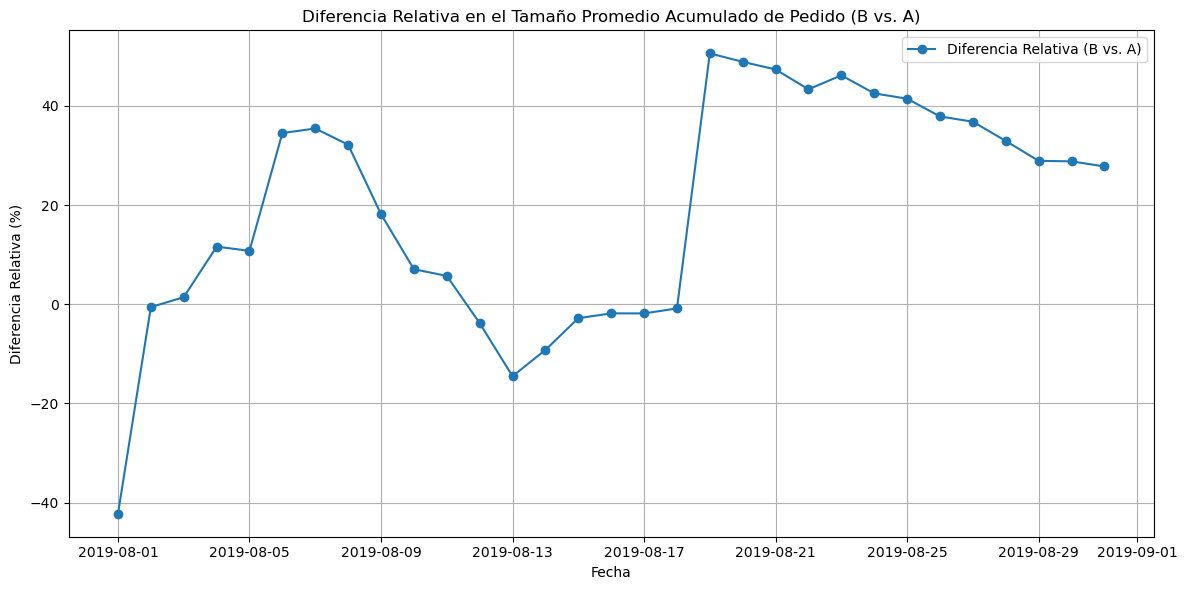

In [35]:
# Graficamos.

plt.figure(figsize=(12,6))
plt.plot(merged_A_B['date'], merged_A_B['relative_difference'], marker='o', label='Diferencia Relativa (B vs. A)')

plt.title('Diferencia Relativa en el Tamaño Promedio Acumulado de Pedido (B vs. A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia Relativa (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



**Notas:**

El grupo B inicialmente tuvo un tamaño promedio de pedido menor al grupo A, pero a partir del 5 de agosto mostró un rendimiento superior, alcanzando picos significativos alrededor del 17 de agosto. Esto indica que la estrategia aplicada al grupo B fue más efectiva en ciertos períodos, aunque con fluctuaciones. Se recomienda investigar los picos y validar estadísticamente las diferencias observadas para confirmar la eficacia de la estrategia del grupo B.

## Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día


In [37]:
# Calcular la tasa de conversión para cada grupo.

ordenes_acumuladas['conversion_rate'] = ((ordenes_acumuladas['cumulative_transactions'] / ordenes_acumuladas['cumulative_visitors']) * 100).round(1)


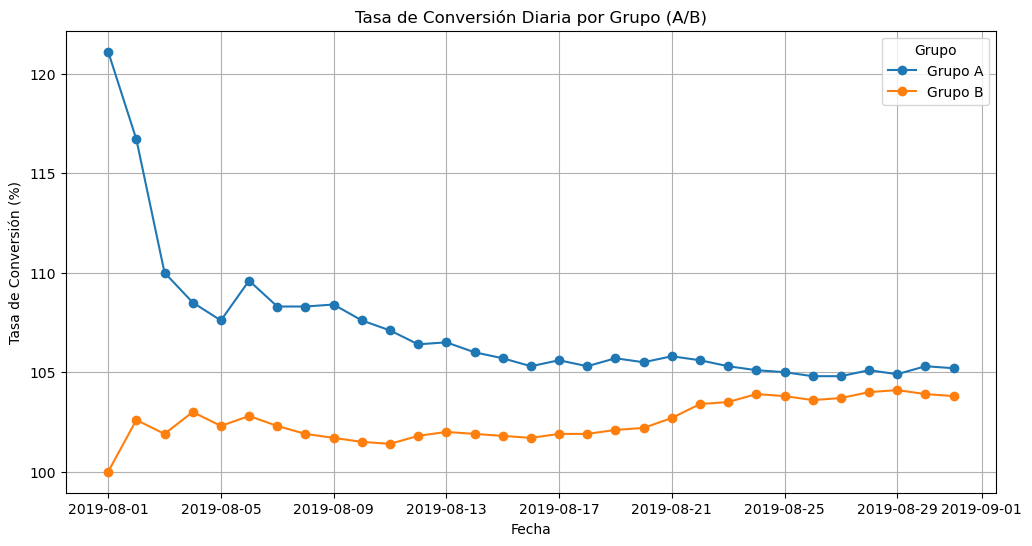

In [38]:
# Graficamos la tasa de conversión.

# Separar los datos de los grupos A y B.
tasa_conversion_A = ordenes_acumuladas[ordenes_acumuladas['group'] == 'A']
tasa_conversion_B = ordenes_acumuladas[ordenes_acumuladas['group'] == 'B']


plt.figure(figsize=(12, 6))
plt.plot(tasa_conversion_A['date'], tasa_conversion_A['conversion_rate'], label='Grupo A', marker='o')
plt.plot(tasa_conversion_B['date'], tasa_conversion_B['conversion_rate'], label='Grupo B', marker='o')

plt.title('Tasa de Conversión Diaria por Grupo (A/B)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Conversión (%)')
plt.legend(title='Grupo')
plt.grid(True)

plt.show()






**Notas:** 

El grupo A comenzó con una tasa de conversión más alta, pero experimentó una disminución significativa antes de estabilizarse. El grupo B, aunque tuvo tasas de conversión más bajas durante todo el período, mostró mayor consistencia y cerró la brecha hacia el final.

## Traza un gráfico de dispersión del número de pedidos por usuario

In [40]:
# Calcular el número de pedidos por usuario.

pedidos_por_usuario = ordenes.groupby('visitor_id')['transaction_id'].count().reset_index()

pedidos_por_usuario.columns = ['visitor_id', 'total_orders']


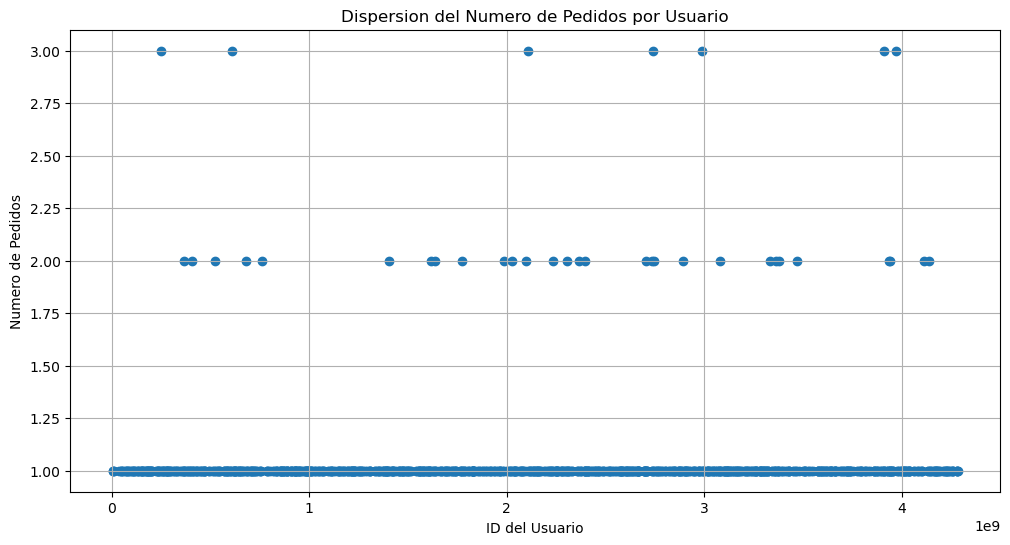

In [41]:
# Graficamos el numero de pedidos por usuario.

plt.figure(figsize=(12,6))
plt.scatter(pedidos_por_usuario['visitor_id'], pedidos_por_usuario['total_orders'])

plt.title('Dispersion del Numero de Pedidos por Usuario')
plt.xlabel('ID del Usuario')
plt.ylabel('Numero de Pedidos')
plt.grid(True)

plt.show()




**Notas:** 

La mayoría de los usuarios realizaron un solo pedido, como lo indica la gran densidad de puntos en el nivel de 1 en el eje Y. Solo unos pocos usuarios realizaron 2 o 3 pedidos, lo que sugiere que los clientes recurrentes son una minoría.

Los usuarios que realizan más de un pedido podrían representar clientes más leales o responder a estrategias específicas, como promociones. Sería útil analizar qué factores motivan a estos usuarios a repetir pedidos para fomentar esta conducta en otros.

## Calcula los percentiles 95 y 99 del número de pedidos por usuario

In [47]:
# Calcular los percentiles 95 y 99.

percentil_95 = np.percentile(pedidos_por_usuario['total_orders'], 95)
percentil_99 = np.percentile(pedidos_por_usuario['total_orders'], 99)

print('percentil_95 del numero de pedidos por usuario:', percentil_95)
print('percentil_99 del numero de pedidos por usuario:', percentil_99)
print()

print('Conclusion:')

print()
print("""Cualquier usuario con más de 2 pedidos se consideraría una anomalía.
ya que el percentil 99 corresponde a 2 pedidos.
Este punto indica que solo el 1% de los usuarios realiza más de 2 pedidos, por lo que son casos atípicos que deben analizarse en detalle.""")


percentil_95 del numero de pedidos por usuario: 1.0
percentil_99 del numero de pedidos por usuario: 2.0

Conclusion:

Cualquier usuario con más de 2 pedidos se consideraría una anomalía.
ya que el percentil 99 corresponde a 2 pedidos.
Este punto indica que solo el 1% de los usuarios realiza más de 2 pedidos, por lo que son casos atípicos que deben analizarse en detalle.


## Traza un gráfico de dispersión de los precios de los pedidos

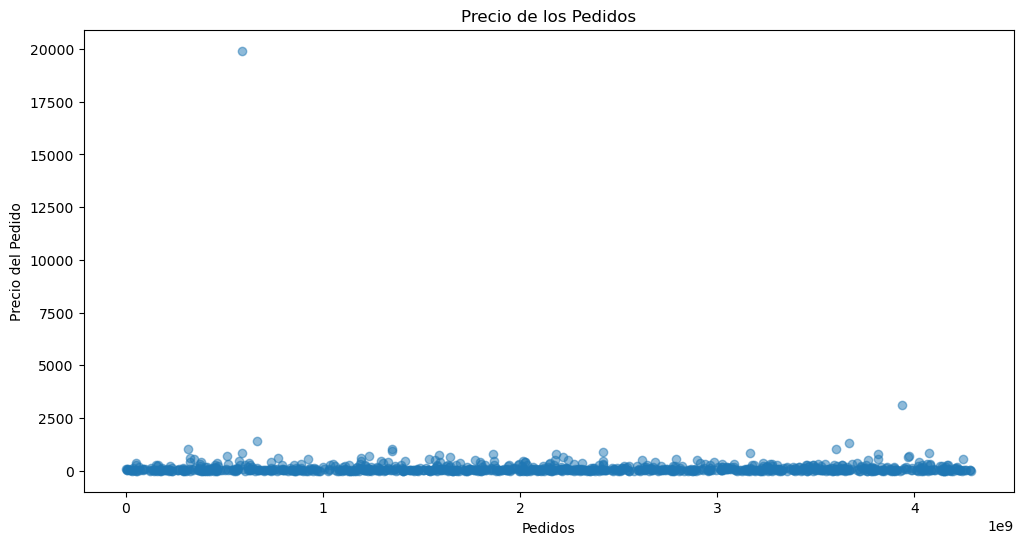

In [42]:
# Graficamos los precios de los pedidos.

plt.figure(figsize=(12,6))
plt.scatter(ordenes['transaction_id'], ordenes['revenue'], alpha=0.5)
plt.title('Precio de los Pedidos')
plt.xlabel('Pedidos')
plt.ylabel('Precio del Pedido')
plt.show()

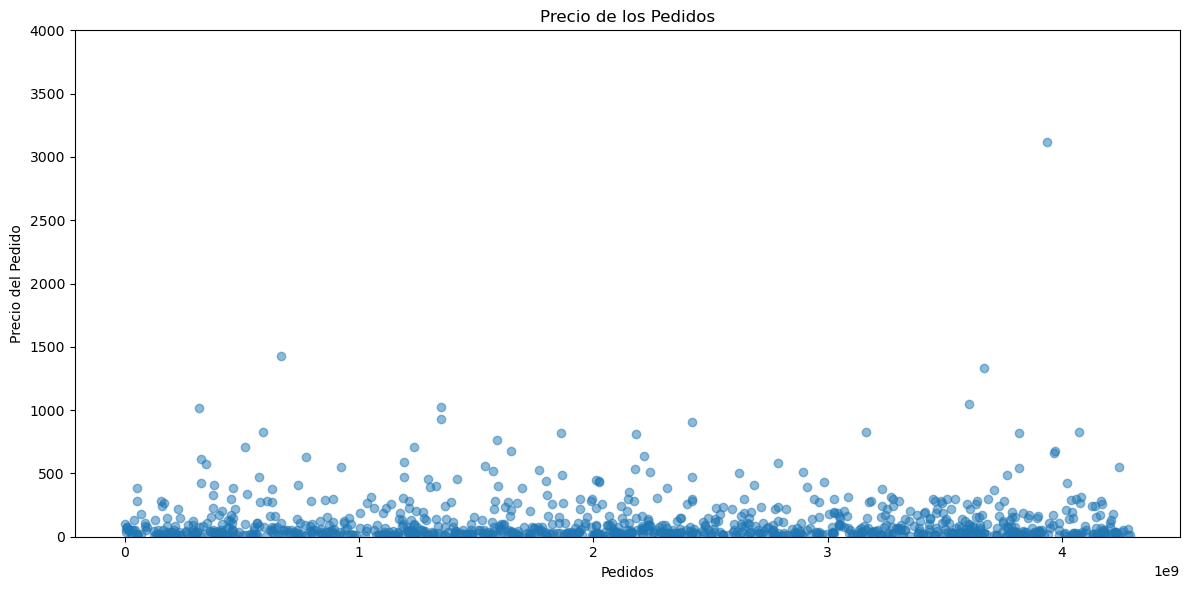

In [44]:
# Ajustamos el rango a 4000, para poder vizucalizar mejor.

plt.figure(figsize=(12, 6))
plt.scatter(ordenes['transaction_id'], ordenes['revenue'], alpha=0.5)
plt.ylim(0, 4000)  
plt.title('Precio de los Pedidos')
plt.xlabel('Pedidos')
plt.ylabel('Precio del Pedido')
plt.tight_layout()
plt.show()


**Notas:**

El gráfico muestra una gran cantidad de pedidos con precios relativamente bajos (mayoritariamente por debajo de $500), mientras que unos pocos pedidos se destacan con precios significativamente más altos, incluso superando los $3,000.

Esto indica la presencia de outliers o valores atípicos en el precio de los pedidos, lo cual podría afectar el promedio general. La distribución sugiere que la mayoría de las transacciones tienen un comportamiento concentrado, pero existen algunos pedidos inusuales con montos elevados.

## Calcula los percentiles 95 y 99 de los precios de los pedidos

In [45]:
# Calculamos los percentiles 95 y 99 de los precios de los pedidos.

percentil_95 = np.percentile(ordenes['revenue'], 95)
percentil_99 = np.percentile(ordenes['revenue'], 99)

print('percentil_95 del precio de los pedidos:', percentil_95)
print('percentil_99 del predio de los pedidos:', percentil_99)
print()

print('Conclusion:')
print()
print('El 95% de los pedidos tienen precios menores o iguales a 414.28, mientras que el 99% de los pedidos tienen precios menores o iguales a 830.30. Esto indica que la mayoría de los pedidos están en un rango de precios moderado, y solo un pequeño porcentaje de pedidos tienen precios significativamente más altos, lo que los convierte en valores atípicos.')
print('Recomendación: Investigar los pedidos que superan el percentil 99 para confirmar su validez y explorar si representan una oportunidad para aumentar el ticket promedio o fidelizar a los clientes de alto valor.')

percentil_95 del precio de los pedidos: 414.275
percentil_99 del predio de los pedidos: 830.3

Conclusion:

El 95% de los pedidos tienen precios menores o iguales a 414.28, mientras que el 99% de los pedidos tienen precios menores o iguales a 830.30. Esto indica que la mayoría de los pedidos están en un rango de precios moderado, y solo un pequeño porcentaje de pedidos tienen precios significativamente más altos, lo que los convierte en valores atípicos.
Recomendación: Investigar los pedidos que superan el percentil 99 para confirmar su validez y explorar si representan una oportunidad para aumentar el ticket promedio o fidelizar a los clientes de alto valor.


## Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto

In [43]:
ordenes_bruto['date'] = pd.to_datetime(ordenes_bruto['date'])

# Calcular el número de pedidos diarios por grupo.

pedidos_diarios_bruto = ordenes_bruto.groupby(['date', 'group'], as_index=False).agg({'transactionId': 'count'})
pedidos_diarios_bruto.rename(columns={'transactionId': 'total_orders'}, inplace=True)

# Combinar con la tabla de visitas para calcular la tasa de conversión.

conversion_diaria_bruto = pd.merge(visitas, pedidos_diarios_bruto, on=['date', 'group'])
conversion_diaria_bruto['conversion_rate'] = (conversion_diaria_bruto['total_orders'] / conversion_diaria_bruto['visits']) * 100

# Separar las tasas de conversión por grupo.

conversion_A_bruto = conversion_diaria_bruto[conversion_diaria_bruto['group'] == 'A']['conversion_rate']
conversion_B_bruto = conversion_diaria_bruto[conversion_diaria_bruto['group'] == 'B']['conversion_rate']

# Realizar la prueba de Mann-Whitney.

results_bruto = st.mannwhitneyu(conversion_A_bruto, conversion_B_bruto, alternative='two-sided')

p_value_bruto = results_bruto.pvalue
alpha = 0.05

if p_value_bruto < alpha:
    conclusion_bruto = "Hipótesis nula rechazada: existen diferencias significativas en la conversión entre los grupos."
else:
    conclusion_bruto = "No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa."

# Mostrar resultados
print("p-valor (datos en bruto):", p_value_bruto)
print("Conclusión (datos en bruto):", conclusion_bruto)
print()
print('Los datos sugieren que las estrategias aplicadas a los grupos A y B tienen un impacto similar en las tasas de conversión. Esto podría deberse a que ambas estrategias no son lo suficientemente diferentes para provocar un cambio en el comportamiento de los usuarios.')

p-valor (datos en bruto): 0.08587216033007773
Conclusión (datos en bruto): No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa.

Los datos sugieren que las estrategias aplicadas a los grupos A y B tienen un impacto similar en las tasas de conversión. Esto podría deberse a que ambas estrategias no son lo suficientemente diferentes para provocar un cambio en el comportamiento de los usuarios.


## Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto

In [44]:
# Obtener los ingresos por pedido para cada grupo.

revenue_A_bruto = ordenes_bruto[ordenes_bruto['group'] == 'A']['revenue']
revenue_B_bruto = ordenes_bruto[ordenes_bruto['group'] == 'B']['revenue']

# Realizar la prueba de Mann-Whitney.

results = st.mannwhitneyu(revenue_A_bruto, revenue_B_bruto)


p_value = results.pvalue

# Nivel de significancia.

alpha = 0.05


if p_value < alpha:
    conclusion = "Hipótesis nula rechazada: existen diferencias significativas en el tamaño promedio de pedido entre los grupos."
else:
    conclusion = "No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa."

print("p-valor:", p_value)
print("Conclusión:", conclusion)
print()
print('Es probable que los usuarios de ambos grupos tengan patrones de gasto similares, lo que resulta en tamaños promedio de pedido prácticamente iguales. Esto sugiere que las estrategias aplicadas a los grupos no afectan significativamente el monto promedio de las transacciones.')


p-valor: 0.6915246773264736
Conclusión: No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa.

Es probable que los usuarios de ambos grupos tengan patrones de gasto similares, lo que resulta en tamaños promedio de pedido prácticamente iguales. Esto sugiere que las estrategias aplicadas a los grupos no afectan significativamente el monto promedio de las transacciones.


## Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados




In [45]:
# Calcular el número de pedidos diarios por grupo.

pedidos_diarios = ordenes.groupby(['date', 'group'], as_index=False).agg({'transaction_id': 'count'})
pedidos_diarios.rename(columns={'transaction_id': 'total_orders'}, inplace=True)

# Combinar con la tabla de visitas para calcular la tasa de conversión.

conversion_diaria = pd.merge(visitas, pedidos_diarios, on=['date', 'group'])
conversion_diaria['conversion_rate'] = (conversion_diaria['total_orders'] / conversion_diaria['visits']) * 100

# Separar las tasas de conversión por grupo.

conversion_A = conversion_diaria[conversion_diaria['group'] == 'A']['conversion_rate']
conversion_B = conversion_diaria[conversion_diaria['group'] == 'B']['conversion_rate']

# Realizar la prueba de Mann-Whitney.

results = st.mannwhitneyu(conversion_A, conversion_B)


p_value = results.pvalue
alpha = 0.05

if p_value < alpha:
    conclusion = "Hipótesis nula rechazada: existen diferencias significativas en la conversión entre los grupos."
else:
    conclusion = "No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa."


print("p-valor:", p_value)
print("Conclusión:", conclusion)
print()
print('Aunque el grupo B puede tener una tasa de conversión ligeramente diferente (en promedio), esta diferencia no es estadísticamente significativa. Esto podría indicar que las estrategias aplicadas a ambos grupos tienen un impacto similar en la conversión.')

p-valor: 0.05375707890473213
Conclusión: No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa.

Aunque el grupo B puede tener una tasa de conversión ligeramente diferente (en promedio), esta diferencia no es estadísticamente significativa. Esto podría indicar que las estrategias aplicadas a ambos grupos tienen un impacto similar en la conversión.


## Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados

In [46]:
# Obtener los ingresos por pedido para cada grupo.

revenue_A = ordenes[ordenes['group'] == 'A']['revenue']
revenue_B = ordenes[ordenes['group'] == 'B']['revenue']

# Realizar la prueba de Mann-Whitney.

results = st.mannwhitneyu(revenue_A, revenue_B)


p_value = results.pvalue

# Nivel de significancia.

alpha = 0.05


if p_value < alpha:
    conclusion = "Hipótesis nula rechazada: existen diferencias significativas en el tamaño promedio de pedido entre los grupos."
else:
    conclusion = "No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa."

print("p-valor:", p_value)
print("Conclusión:", conclusion)
print()
print('Es probable que los usuarios de ambos grupos tengan patrones de gasto similares, lo que resulta en tamaños promedio de pedido prácticamente iguales. Esto sugiere que las estrategias aplicadas a los grupos no afectan significativamente el monto promedio de las transacciones.')



p-valor: 0.8622329690015668
Conclusión: No se pudo rechazar la hipótesis nula: no hay evidencia suficiente para concluir una diferencia significativa.

Es probable que los usuarios de ambos grupos tengan patrones de gasto similares, lo que resulta en tamaños promedio de pedido prácticamente iguales. Esto sugiere que las estrategias aplicadas a los grupos no afectan significativamente el monto promedio de las transacciones.


## Toma una decisión basada en los resultados de la prueba

Decisión 2  Parar la prueba y concluir que no hay diferencias significativas entre los grupos.

Justificación:

Las pruebas estadísticas no encontraron diferencias significativas en las métricas clave (tasa de conversión y tamaño promedio de pedido).
Continuar la prueba podría no ser eficiente dado que los datos actuales sugieren que las estrategias tienen un impacto similar.
Sin embargo, se pueden tomar aprendizajes del grupo B (por ejemplo, los picos en tamaño promedio de pedido) para diseñar futuras pruebas o estrategias.

# Conclusión General del Proyecto


1. Priorización de Hipótesis:

Resultado: La hipótesis "Add a subscription form to all the main pages" fue priorizada debido a su puntaje más alto en RICE. Esto indica que es la más prometedora para aumentar los ingresos al afectar a un mayor número de usuarios.

2. Análisis del Test A/B:

Ingresos acumulados:
El grupo B generó ingresos acumulados mayores en comparación con el grupo A.

Sin embargo, no se realizó una prueba estadística que demostrara que esta diferencia es significativa.

Tamaño promedio de pedido acumulado:
El grupo B mostró picos en el tamaño promedio de pedido, especialmente alrededor del 17 de agosto.
El grupo A tuvo un comportamiento más estable.

Diferencia relativa en tamaño promedio:
A partir del 5 de agosto, el grupo B superó consistentemente al grupo A en tamaño promedio de pedido, aunque con fluctuaciones. Esto sugiere que la estrategia aplicada al grupo B fue más efectiva en ciertos períodos.

Tasa de conversión:
El grupo A tuvo una mayor tasa de conversión inicial, pero mostró una disminución y se estabilizó.
El grupo B tuvo tasas de conversión más consistentes y cerró la brecha hacia el final del período.

3. Análisis de Anomalías:

Número de pedidos por usuario:
El percentil 99 indica que los usuarios con más de 2 pedidos son casos atípicos.
La mayoría de los usuarios realizaron solo un pedido.

Precios de los pedidos:
El 95% de los pedidos tienen precios menores o iguales a 414.20, mientras que el 99% en 830.30.
Un pedido con un precio de $20,000 se identificó como un valor atípico que debería investigarse.

4. Significancia Estadística:

Conversión (datos en bruto y filtrados):
No se encontraron diferencias estadísticamente significativas en las tasas de conversión entre los grupos A y B 

p=0.0859.

Tamaño promedio de pedido (datos en bruto y filtrados):
Tampoco se encontraron diferencias significativas en el tamaño promedio de pedido entre los grupos (

p=0.69 en datos en bruto y 

p=0.86 en datos filtrados).


Decisión Final:

Decisión 2 Parar la prueba y concluir que no hay diferencias significativas entre los grupos.

Justificación:

Las pruebas estadísticas no encontraron diferencias significativas en las métricas clave (tasa de conversión y tamaño promedio de pedido).
Continuar la prueba podría no ser eficiente dado que los datos actuales sugieren que las estrategias tienen un impacto similar.
Sin embargo, se pueden tomar aprendizajes del grupo B (por ejemplo, los picos en tamaño promedio de pedido) para diseñar futuras pruebas o estrategias.
